In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install japanize-matplotlib

In [3]:
# 必要なパッケージをインポート
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from statsmodels.graphics.tsaplots import plot_acf

In [4]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt

In [5]:
print(np.__version__)
print(pm.__version__)
print(az.__version__)

1.25.2
5.10.4
0.15.1


## データの準備など

In [6]:
# データ用意
parray = pd.read_csv(f"/content/gdrive/MyDrive/RとStanで学ぶベイズ統計/data/4-3-1-fish-num-4.csv")
df = pd.DataFrame(parray)
print(df.shape)
display(df.head())

(94, 3)


,fish_num,temperature,human
0,2,12.7,A
1,6,13.7,B
2,9,15.7,C
3,5,19.1,D
4,11,12.0,E


In [7]:
df["human"].value_counts()

human
A    10
B    10
C    10
D    10
E    10
F    10
G    10
H    10
I    10
J     4
Name: count, dtype: int64

### 可視化

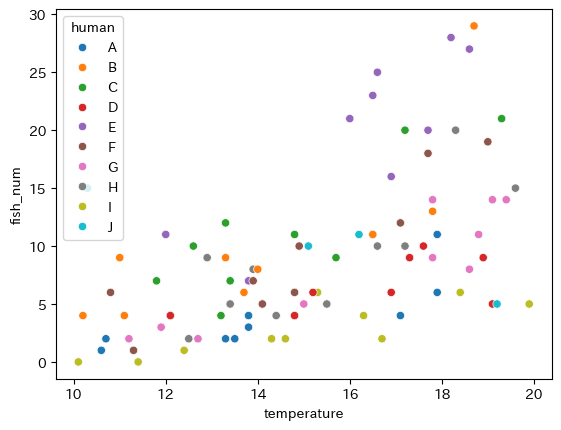

In [8]:
# データの可視化(humanごと)
fig, ax = plt.subplots()
ax = sns.scatterplot(x = parray["temperature"], y = parray["fish_num"],
                     hue = parray["human"])

## 交互作用を用いたモデル化

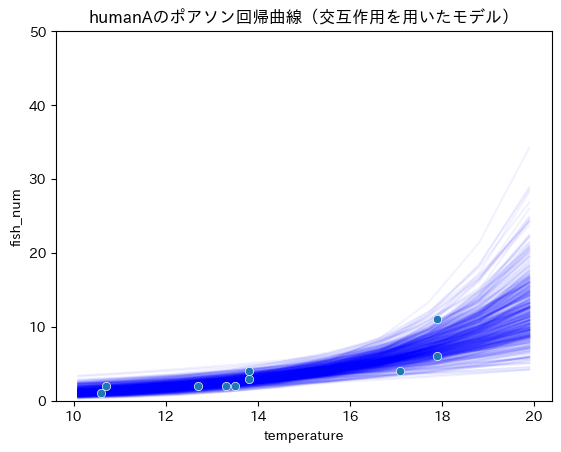

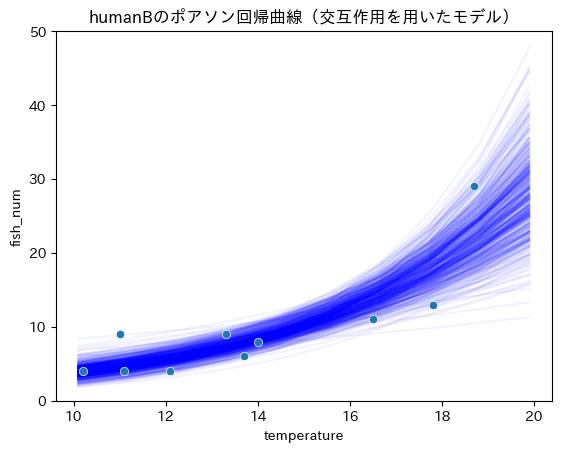

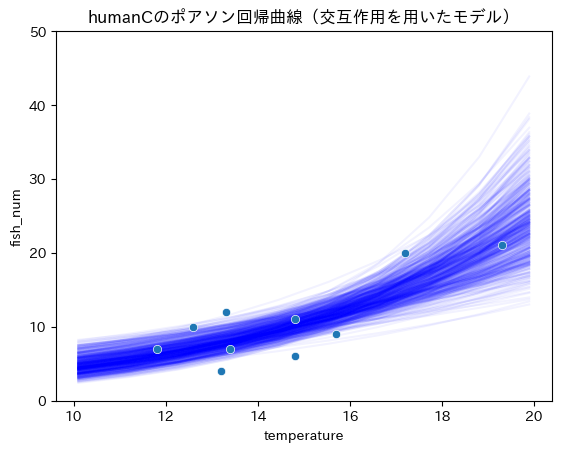

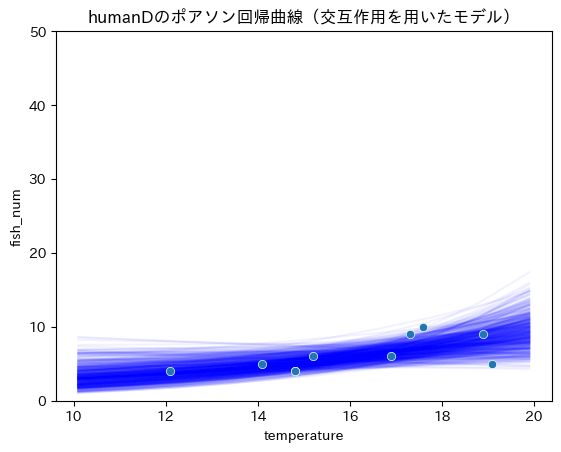

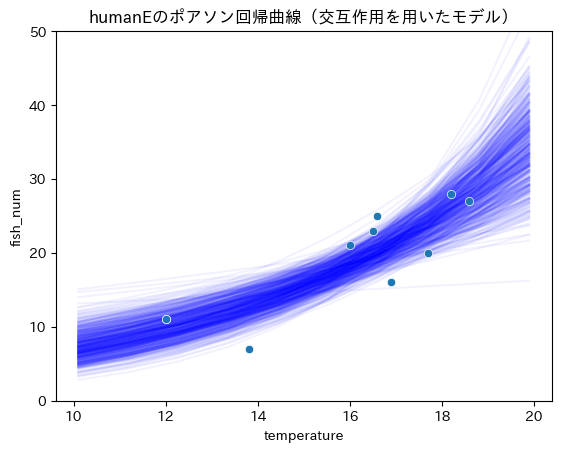

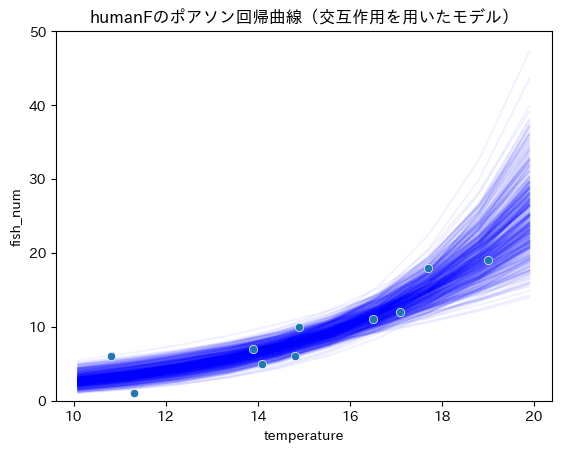

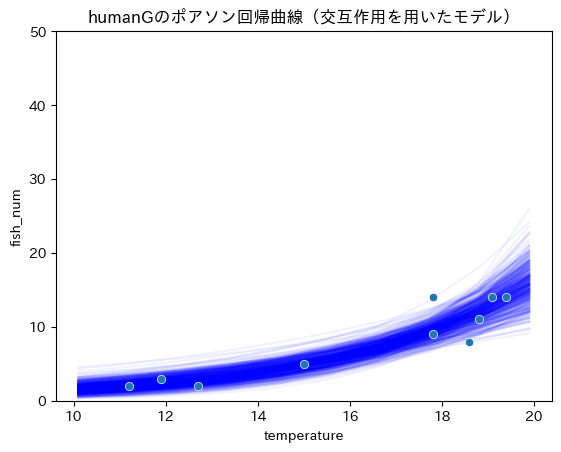

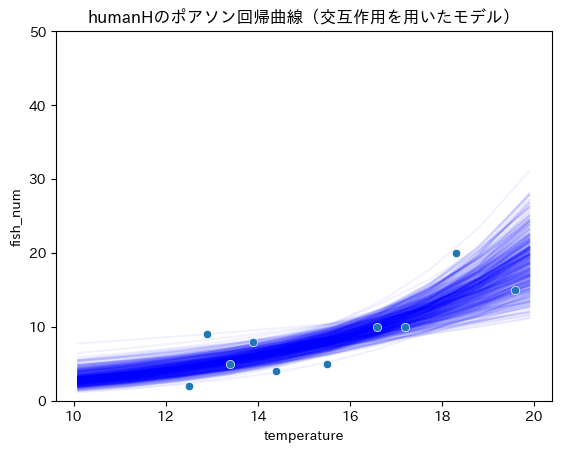

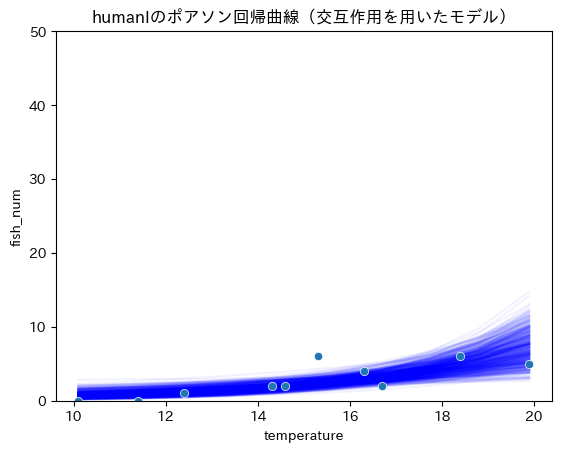

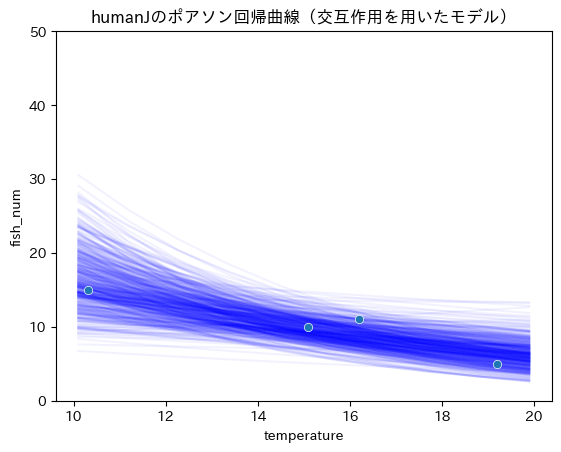

In [9]:
for name in df["human"].unique().tolist():
  # データの準備
  # Aのフラグカラムを作成
  df["human_flg"] = 0
  df.loc[df["human"]==name, "human_flg"] = 1

  # 交互作用項を作成
  df["human_temperature"] = df["temperature"] * df["human_flg"]

  # 各カラムを配列を作成
  y = df["fish_num"].values
  temperature = df["temperature"].values
  human_flg =  df["human_flg"].values
  human_temperature =  df["human_temperature"].values

  # ベイズモデリング
  model_interaction = pm.Model()
  with model_interaction:
      # 確率モデルの定義
      # 観測値をConstantDataとして定義
      y_data = pm.Data("y_data", y, mutable=True)
      temperature_data = pm.Data("temperature_data", temperature, mutable=True)
      human_data = pm.Data("human_data", human_flg, mutable=True)
      human_temperature_data = pm.Data("human_temperature_data", human_temperature, mutable=True)
      # パラメータを確率変数として定義
      b0 = pm.Normal("b0", mu=0, sigma=10)
      bt = pm.Normal("bt", mu=0, sigma=10)
      bh = pm.Normal("bh", mu=0, sigma=10)
      bht = pm.Normal("bht", mu=0, sigma=10)
      # 目的変数の期待値を確率変数として定義
      exp_lambda_ = pm.Deterministic("exp_lambda_",
                                    pt.exp(bt * temperature_data + bh * human_data
                                            + bht * human_temperature_data + b0))
      # 観測値を持つ確率変数として定義
      y_obs = pm.Poisson("y_obs", mu=exp_lambda_, observed=y_data)

      # パラメータのMCMCサンプリング
      idata_intrctn = pm.sample(
          chains = 2,
          tune = 3000,
          draws = 1000,
          random_seed = 42,
      )

  # 描画
  # 描画したい範囲の温度データの配列作成
  t_min = df["temperature"].min()
  t_max = df["temperature"].max()
  plot_num = 10
  t_data =  np.linspace(t_min, t_max, plot_num)

  # 各パラメータを抽出
  bt_array = idata_intrctn.posterior["bt"].values[0, :500].reshape(500, 1)
  bh_array = idata_intrctn.posterior["bh"].values[0, :500].reshape(500, 1)
  bht_array = idata_intrctn.posterior["bht"].values[0, :500].reshape(500, 1)
  b0_array = idata_intrctn.posterior["b0"].values[0, :500].reshape(500, 1)

  # 釣獲尾数の強度の計算
  lambda_ = (bt_array + bht_array) @ t_data.reshape(1, 10) + bh_array + b0_array

  # 釣獲尾数の期待値の計算
  e = np.exp(lambda_)

  # ポアソン回帰曲線の描画
  for y_pred in e:
    sns.lineplot(x=t_data, y=y_pred, color = "b", alpha=0.05, zorder=1)

  # 観測データの散布図を描画
  ax = sns.scatterplot(x = df[df["human"] == name]["temperature"],
                      y = df[df["human"] == name]["fish_num"],
                      zorder=2)
  ax.set(ylim=(0, 50))
  ax.set_title(f"human{name}のポアソン回帰曲線（交互作用を用いたモデル）")
  plt.show();


In [10]:
# Jのみ温度に対して負の傾向。データ数が少ないためと想定できる。ランダム係数モデルの縮約によって、モデリングしてみる。

## ランダム係数モデル

In [11]:
# データ用意
parray = pd.read_csv(f"/content/gdrive/MyDrive/RとStanで学ぶベイズ統計/data/4-3-1-fish-num-4.csv")
df = pd.DataFrame(parray)
print(df.shape)
display(df.head())

(94, 3)


,fish_num,temperature,human
0,2,12.7,A
1,6,13.7,B
2,9,15.7,C
3,5,19.1,D
4,11,12.0,E


In [12]:
# 各カラムの配列を作成
y = df["fish_num"].values
temperature = df["temperature"].values
cl = pd.Categorical(df["human"]).codes

print(y[:5])
print(temperature[:5])
print(cl)

[ 2  6  9  5 11]
[12.7 13.7 15.7 19.1 12. ]
[0 1 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8 0
 1 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8 0 1
 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8 9 9 9 9]


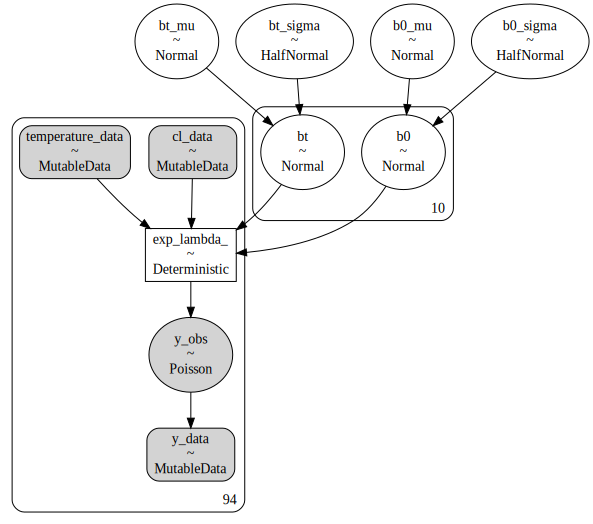

In [13]:
# 確率モデルの定義
model_randomSlope = pm.Model()

with model_randomSlope:
    # 観測値をConstantDataとして定義
    y_data = pm.Data("y_data", y, mutable=True)
    temperature_data = pm.Data("temperature_data", temperature, mutable=True)

    # クラス変数を定義
    cl_data = pm.Data("cl_data", cl, mutable=True)

    # 切片（パラメータ）を確率変数として定義（階層ベイズ）
    b0_mu = pm.Normal("b0_mu", mu=0, sigma=10)
    b0_sigma = pm.HalfNormal("b0_sigma", sigma=10)
    b0 = pm.Normal("b0", mu=b0_mu, sigma=b0_sigma, shape=(10,))

    # 温度の回帰係数（パラメータ）を確率変数として定義（階層ベイズ）
    bt_mu = pm.Normal("bt_mu", mu=0, sigma=10)
    bt_sigma = pm.HalfNormal("bt_sigma", sigma=10)
    bt = pm.Normal("bt", mu=bt_mu, sigma=bt_sigma, shape=(10,))

    # 目的変数の期待値を確率変数として定義
    exp_lambda_ = pm.Deterministic("exp_lambda_",
                                   pt.exp(bt[cl_data] * temperature_data + b0[cl_data]))

    # 観測値を持つ確率変数として定義
    y_obs = pm.Poisson("y_obs", mu=exp_lambda_, observed=y_data)

g = pm.model_to_graphviz(model_randomSlope)
display(g)

In [14]:
# パラメータのMCMCサンプリング
with model_randomSlope:
    idata_randomSlope = pm.sample(
        chains = 2,
        tune = 4000,
        draws = 1000,
        random_seed = 42,
        # target_accept = 0.99
    )

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


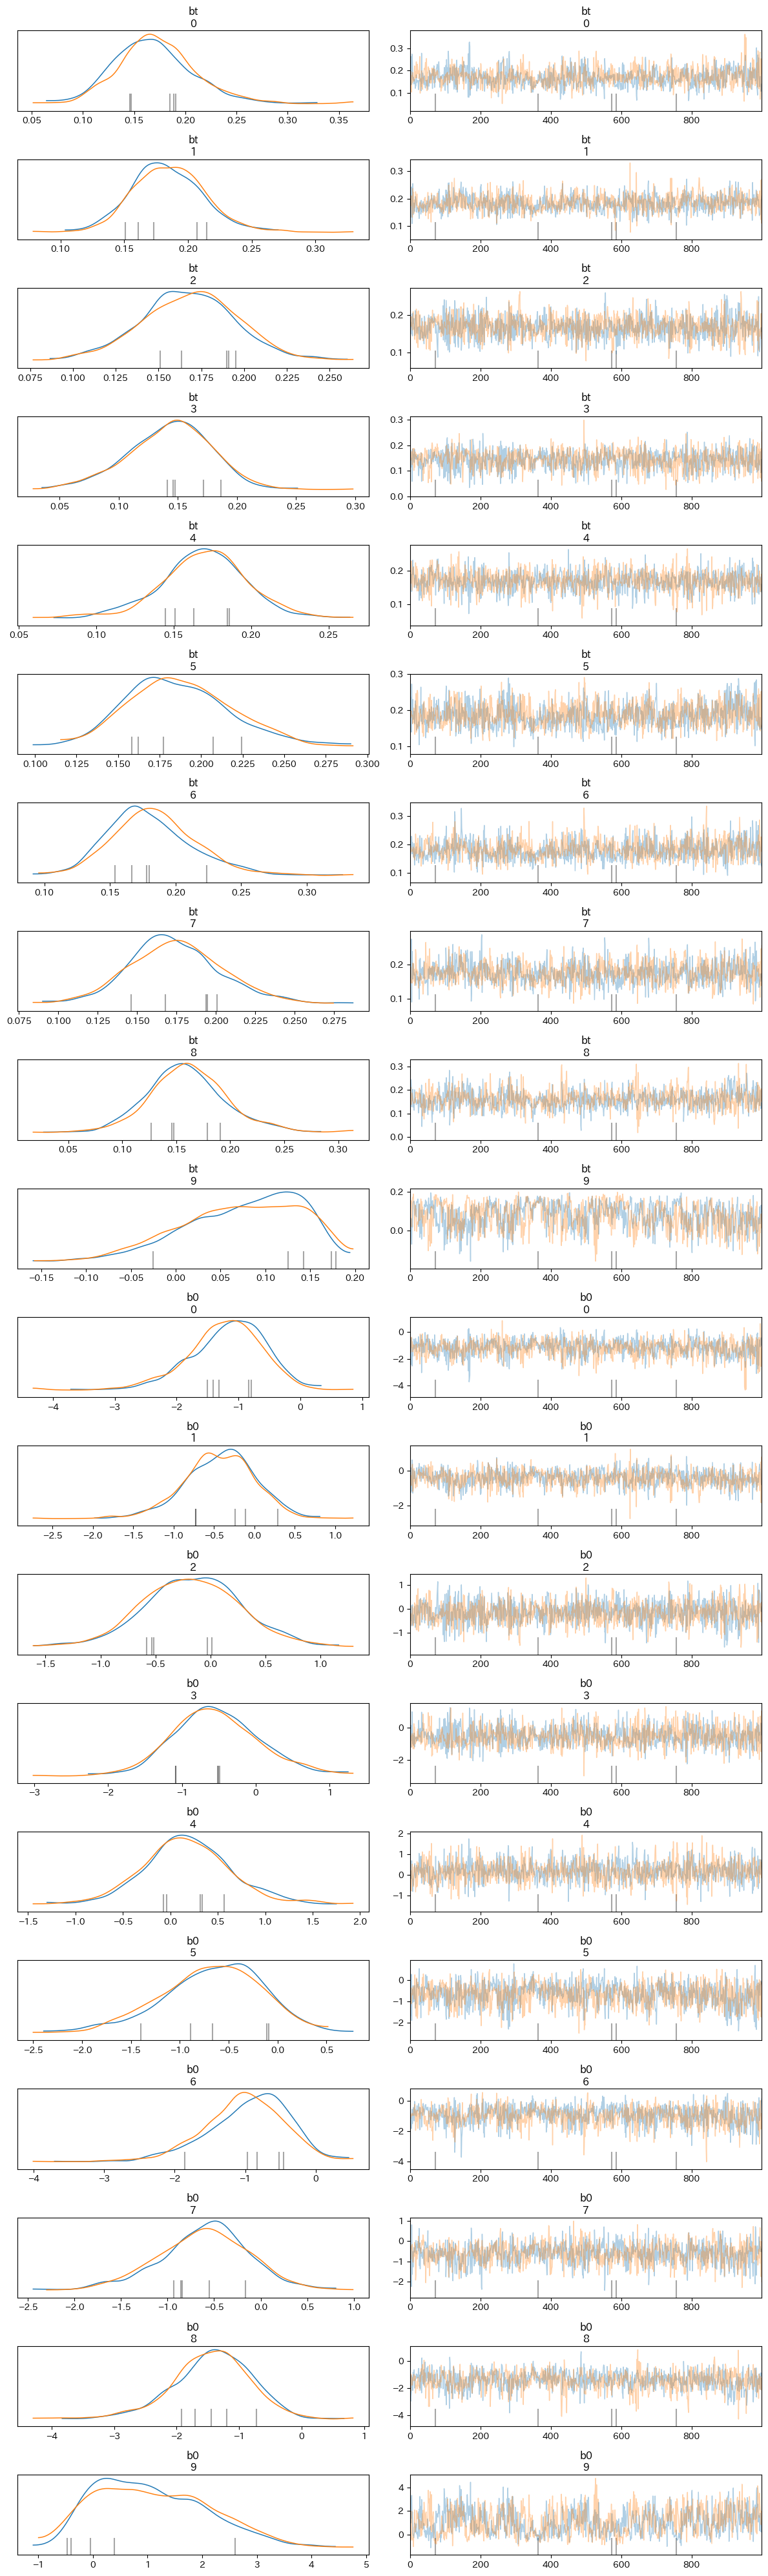

In [15]:
# 事後分布の可視化
az.plot_trace(idata_randomSlope, compact=False, var_names=["bt", "b0"])
plt.tight_layout();

In [16]:
# MCMCサンプルの統計量
az.summary(idata_randomSlope, var_names=["bt", "b0"])

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bt[0],0.171,0.038,0.101,0.243,0.001,0.001,694.0,1049.0,1.01
bt[1],0.184,0.028,0.129,0.234,0.001,0.001,612.0,1315.0,1.00
bt[2],0.168,0.028,0.115,0.223,0.001,0.001,1261.0,1012.0,1.00
bt[3],0.143,0.035,0.071,0.203,0.001,0.001,1168.0,1324.0,1.00
bt[4],0.169,0.028,0.117,0.222,0.001,0.001,1332.0,1321.0,1.00
bt[5],0.187,0.031,0.134,0.250,0.001,0.001,558.0,879.0,1.00
bt[6],0.182,0.033,0.130,0.250,0.001,0.001,547.0,1231.0,1.00
bt[7],0.175,0.030,0.117,0.232,0.001,0.001,764.0,1269.0,1.00
bt[8],0.160,0.037,0.087,0.231,0.001,0.001,642.0,1063.0,1.01
bt[9],0.075,0.065,-0.045,0.177,0.004,0.003,215.0,677.0,1.01


In [17]:
# 描画したい範囲の温度データの配列作成
t_min = df["temperature"].min()
t_max = df["temperature"].max()
plot_num = 10
t_data =  np.linspace(t_min, t_max, plot_num)

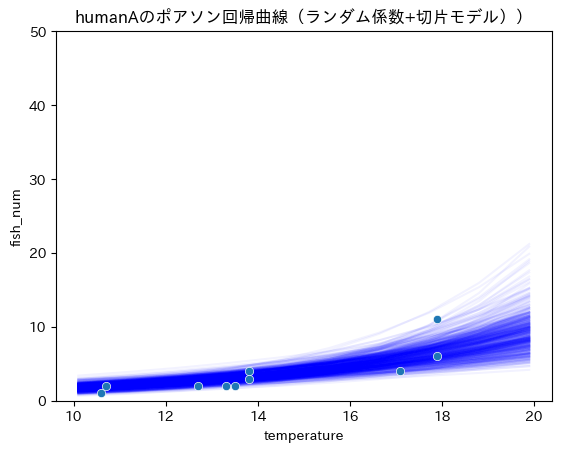

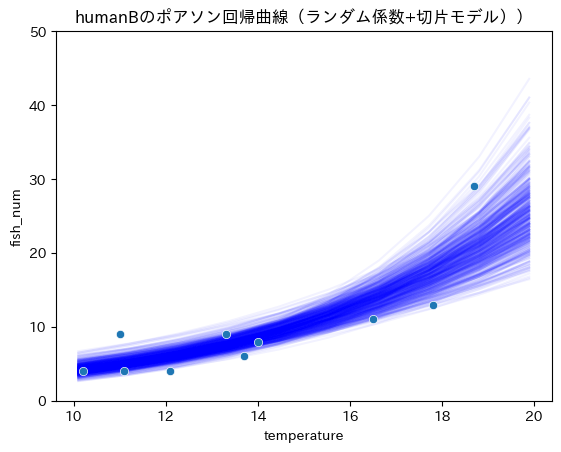

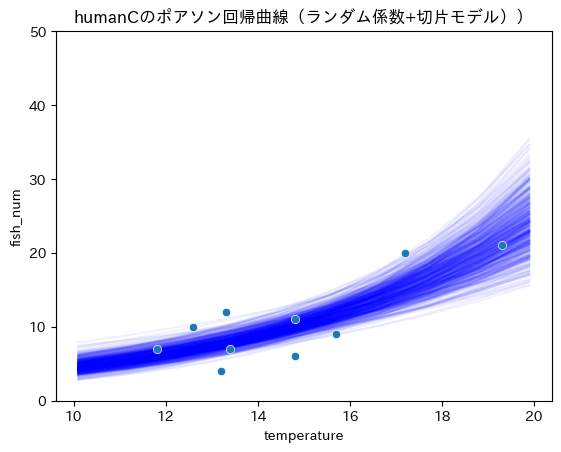

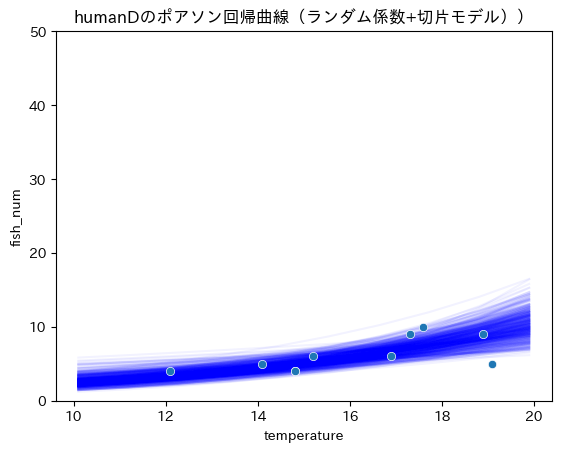

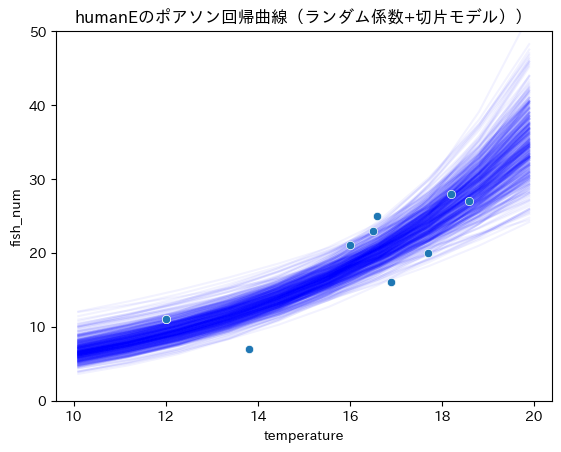

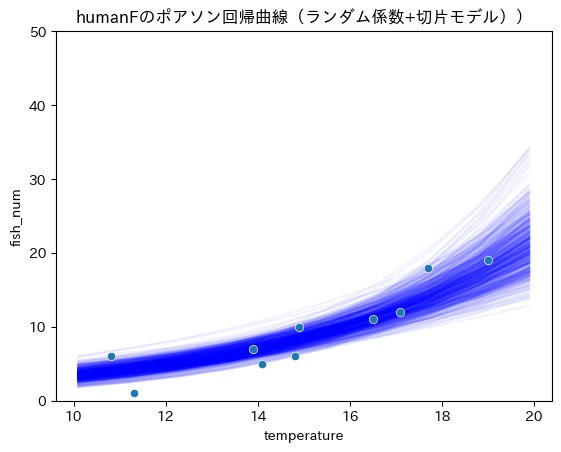

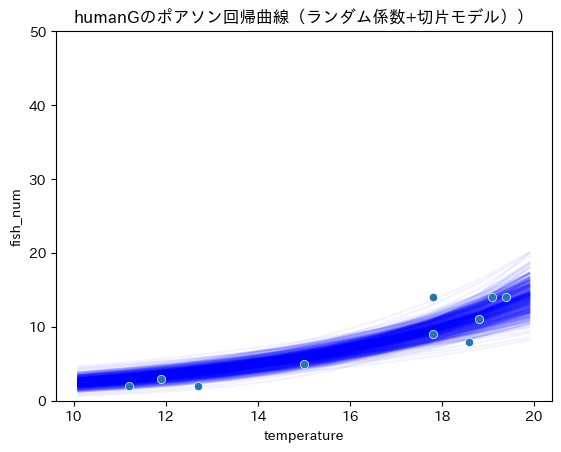

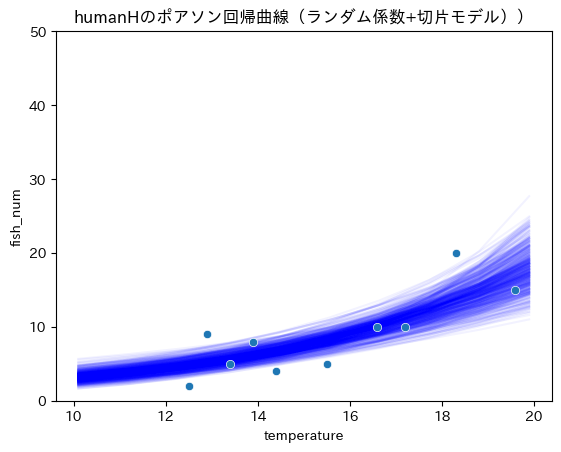

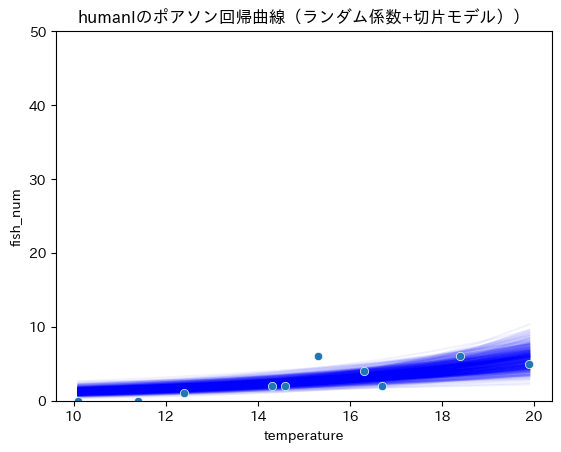

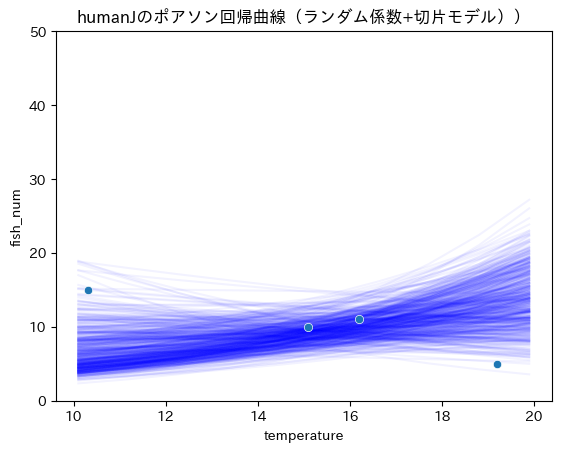

In [18]:
for i, name in enumerate(parray["human"].unique().tolist()):
  # 各人のランダム効果（切片）
  bt_array = idata_randomSlope.posterior["bt"][:, :, i].values[0, :500].reshape(500, 1)
  b0_array = idata_randomSlope.posterior["b0"][:, :, i].values[0, :500].reshape(500, 1)

  # 釣獲尾数の強度の計算
  lambda_ = bt_array @ t_data.reshape(1, 10) + b0_array

  # 釣獲尾数の期待値の計算
  e = np.exp(lambda_)

  # ポアソン回帰曲線の描画
  for y_pred in e:
    sns.lineplot(x=t_data, y=y_pred, color = "b", alpha=0.05, zorder=1)

  # 観測データの散布図を描画
  ax = sns.scatterplot(x = df[df["human"] == name]["temperature"],
                      y = df[df["human"] == name]["fish_num"],
                      zorder=2)
  ax.set(ylim=(0, 50))
  ax.set_title(f"human{name}のポアソン回帰曲線（ランダム係数+切片モデル））")
  plt.show();

In [19]:
# Jも右肩上がりの回帰曲線となっており、縮約の効果が出ている